In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import griddata
from cartopy import config
import os
import h5py
import shutil
from pyproj import CRS, Transformer
import pyproj
import logging
from tqdm import tqdm
from scipy.spatial import ConvexHull, Delaunay
from concurrent.futures import ProcessPoolExecutor, as_completed
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap

# Regular_grid

In [2]:
"""North Pole regular grids, Using NSIDC grid"""
gridn = xr.open_dataset(r"D:\zmh\icecon25000_data\RegularGrid\Grid_n25000.nc")
gridn

# 定义北极规则网格
grid_x_n, grid_y_n = np.meshgrid(
    np.arange(gridn['x'].values.min(), gridn['x'].values.max(), 25000),
    np.arange(gridn['y'].values.min(), gridn['y'].values.max(), 25000)
)

In [3]:
"""South Pole regular grids, Using NSIDC grid"""
grids = xr.open_dataset(r"D:\zmh\icecon25000_data\RegularGrid\Grid_s25000.nc")
grids

# 定义南极规则网格
grid_x_s, grid_y_s = np.meshgrid(
    np.arange(grids['x'].values.min(), grids['x'].values.max(), 25000),
    np.arange(grids['y'].values.min(), grids['y'].values.max(), 25000)
)

In [43]:
grid_x_n.shape, grid_x_s.shape

((447, 303), (331, 315))

# 1. NSIDC-Bootstrap

In [85]:
BS = xr.open_dataset(r"E:\zmh\icecon25000_data\NSIDC-Bootstrap\north\2022\NSIDC0079_SEAICE_PS_N25km_20220101_v4.0.nc")
BS

<xarray.Dataset> Size: 1MB
Dimensions:     (time: 1, y: 448, x: 304)
Coordinates:
  * time        (time) datetime64[ns] 8B 2022-01-01
  * y           (y) float64 4kB 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * x           (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
Data variables:
    F17_ICECON  (time, y, x) float64 1MB ...
    crs         |S1 1B ...
Attributes: (12/49)
    title:                     Bootstrap Sea Ice Concentrations from Nimbus-7...
    summary:                   These sea ice concentration data were derived ...
    id:                        10.5067/X5LG68MH013O
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced by the NASA Cryospheri...
    metadata_link:             https://doi.org/10.5067/X5LG68MH013O
    ...                        ...
    geospatial_y_resolution:   25000.0 meters
    geospatial_lat_min:        30.980564
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    platform:                  DMSP 5D-3/F17 Defense Meteorological Satellite...

In [86]:
BS = BS.drop_vars('crs')
BS = BS.drop('time')
BS['F17_ICECON'] = BS['F17_ICECON'].squeeze()
BS = BS.rename_vars({'F17_ICECON': 'BS_icecon'})

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12364\2692485428.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  BS = BS.drop('time')


In [87]:
BS['BS_icecon'].shape

(448, 304)

## projection

In [88]:
crs_wgs84 = CRS.from_epsg(4326)
crs_psn = CRS.from_epsg(3413)
transformer = Transformer.from_crs(crs_wgs84, crs_psn, always_xy=True)
x = BS['x'].values
y = BS['y'].values
x_grid, y_grid = np.meshgrid(x, y)
lon,lat = transformer.transform(x_grid, y_grid)
BS = BS.assign_coords({'lon': (('y', 'x'), lon), 'lat': (('y', 'x'), lat)})

mask = BS['lat'] >= 60
BS = BS.where(mask, drop=False)

mask = (BS['BS_icecon']>=0) & (BS['BS_icecon']<=1)
BS = BS.where(mask, drop=False)
BS['BS_icecon'] = BS['BS_icecon']*100


In [89]:
BS['BS_icecon'].shape

(448, 304)

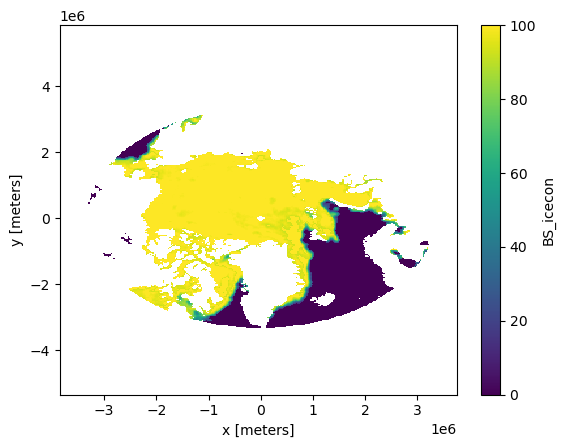

In [90]:
BS['BS_icecon'].plot()

## interpolation(resample)

In [91]:
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()
z_flat = BS['BS_icecon'].values.flatten()
grid_data = griddata((x_flat, y_flat), z_flat, (grid_x_n, grid_y_n), method="nearest")               

## plot

Text(0.5, 1.0, 'NSIDC-Bootstrap_SIC')

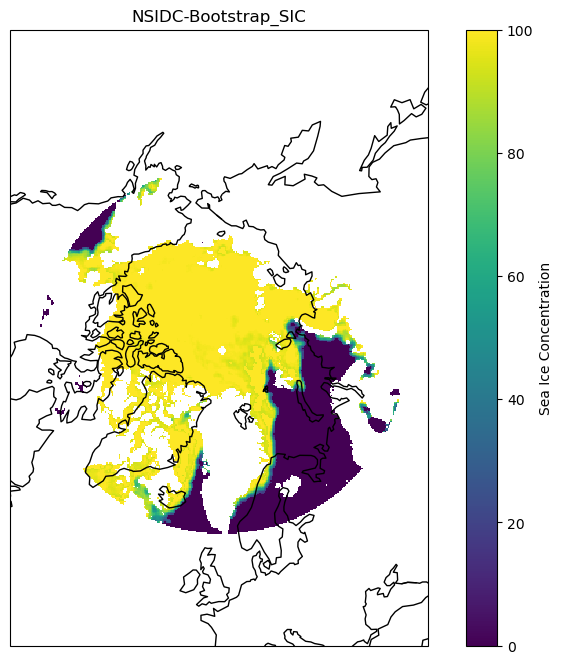

In [93]:
crs_psn = ccrs.NorthPolarStereo()
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=crs_psn)
p = ax.pcolormesh(grid_x_n, grid_y_n, grid_data, transform=crs_psn, cmap='viridis', shading='auto')
ax.coastlines()
plt.colorbar(p, ax=ax, label='Sea Ice Concentration')
plt.title('NSIDC-Bootstrap_SIC')

# 2. NSIDC-NISE

In [9]:
from pyhdf.SD import SD, SDC
file_path  = r"D:\zmh\icecon25000_data\NISE\north\2022\NISE_SSMISF18_20220101.HDFEOS"
hdf_file = SD(file_path, SDC.READ)
datasets = hdf_file.datasets()

extent_ds = hdf_file.select('Extent')
extent = extent_ds[:]


In [2]:
from osgeo import gdal

filename = r"D:\zmh\icecon25000_data\NISE\south\2022\NISE_SSMISF18_20220108.HDFEOS"
dataset = gdal.Open(filename)
subdatasets = dataset.GetSubDatasets()
# For Northern Hemisphere Extent only
north_extent_ds = gdal.Open(subdatasets[0][0]) 
north_extent_array = north_extent_ds.ReadAsArray()
north_extent_ds = None

# For Southern Hemisphere Extent only
south_extent_ds = gdal.Open(subdatasets[2][0]) 
south_extent_array = south_extent_ds.ReadAsArray()
south_extent_ds = None

AttributeError: 'NoneType' object has no attribute 'GetSubDatasets'

In [4]:
import numpy as np
import xarray as xr
from pyproj import Proj, Transformer
from pyhdf.SD import SD, SDC

def process_hdf_eos(file_path, hemisphere='Northern_Hemisphere'):
    """
    处理 HDF-EOS 文件并返回包含经纬度和投影坐标的 xarray.Dataset。

    Args:
        file_path (str): HDF-EOS 文件路径。
        hemisphere (str): 要处理的半球，'Northern_Hemisphere' 或 'Southern_Hemisphere'。

    Returns:
        xarray.Dataset: 包含冰浓度、经纬度和投影坐标的数据集。
    """
    # Step 1: 打开 HDF-EOS 文件
    hdf_file = SD(file_path, SDC.READ)

    # 打印所有可用的数据集，帮助调试
    print("Available datasets:", hdf_file.datasets())
    # 打印文件属性，帮助调试
    print("File attributes:", hdf_file.attributes())

    # Step 2: 提取 Extent 数据
    if hemisphere == 'Northern_Hemisphere':
        # 尝试不同的方法访问 Data_Fields 和 Extent
        # 假设 Data_Fields 在全局属性中被引用，你可以这样尝试：
        # data_fields_name = hdf_file.attributes().get('Data_Fields_Name', 'Data_Fields')  # 假设属性名为 Data_Fields_Name

        # 遍历数据集寻找 extent
        for ds_name in hdf_file.datasets().keys():
            if "Extent" in ds_name:
                extent_ds = hdf_file.select(ds_name)
                extent = extent_ds[:]
                fill_value = extent_ds.attributes().get('_FillValue')
                break
        else:  # 如果没有找到 Extent 数据集
            raise ValueError(f"Extent dataset not found for {hemisphere}")
        
        proj_epsg = Proj("epsg:3408")
        x_min, x_max = -8918565.42, 8918565.42
        y_min, y_max = -8918565.42, 8918565.42
    
    else:  # Southern_Hemisphere
        # 类似地，尝试不同的方法访问 Southern_Hemisphere 的 Data_Fields 和 Extent
        for ds_name in hdf_file.datasets().keys():
            if "Extent" in ds_name:
                extent_ds = hdf_file.select(ds_name)
                extent = extent_ds[:]
                fill_value = extent_ds.attributes().get('_FillValue')
                break
        else:  # 如果没有找到 Extent 数据集
            raise ValueError(f"Extent dataset not found for {hemisphere}")

        proj_epsg = Proj("epsg:3409")
        # 对于南极，你需要根据 EPSG:3409 的定义设置正确的 x_min, x_max, y_min, y_max
        x_min, x_max = -8918565.42, 8918565.42  # 注意：这些值可能需要根据实际情况调整
        y_min, y_max = -8918565.42, 8918565.42  # 注意：这些值可能需要根据实际情况调整
        
    # Step 3: 生成坐标信息
    # 网格大小
    grid_size = extent.shape

    # # 创建投影坐标网格
    # x = np.linspace(x_min, x_max, grid_size[1])
    # y = np.linspace(y_min, y_max, grid_size[0])

    # Grid information from the figure
    ulxmap = -9036842.76  # Upper-left x coordinate (meters)
    ulymap = 9036842.76   # Upper-left y coordinate (meters)
    grid_size = 25067.53  # Grid cell size in meters
    rows = 721            # Number of rows
    cols = 721            # Number of columns

    # Generate x and y coordinates for the grid
    x  = np.linspace(ulxmap, ulxmap + grid_size * (cols - 1), cols)
    y= np.linspace(ulymap, ulymap - grid_size * (rows - 1), rows)

    x_grid, y_grid = np.meshgrid(x, y)

    # Step 4: 反算经纬度
    transformer = Transformer.from_proj(proj_epsg, "epsg:4326", always_xy=True)
    lon, lat = transformer.transform(x_grid, y_grid)

    # 替换无效值 (如 inf) 为 NaN
    lat = np.where(np.isinf(lat), np.nan, lat)
    lon = np.where(np.isinf(lon), np.nan, lon)

    # 替换 extent 中的缺失值为 NaN
    extent = np.where(extent == fill_value, np.nan, extent)

    # Step 5: 构建 xarray.Dataset
    ds = xr.Dataset(
        {
            'ice_concentration': (['y', 'x'], extent),
        },
        coords={
            # 'y': y,
            # 'x': x,
            'lat': (['y', 'x'], lat),
            'lon': (['y', 'x'], lon),
        }
    )

    # only maintain the data with given lon and lat
    if hemisphere == 'Northern_Hemisphere':
        ds = ds.where((ds['lat'] >= 60) & (ds['lat'] <= 90), drop=True)
    else:
        ds = ds.where((ds['lat'] >= -90) & (ds['lat'] <= -60), drop=True)

    # 关闭数据集
    if 'extent_ds' in locals():
      extent_ds.endaccess()

    hdf_file.end()

    return ds

file_path = r"D:\zmh\icecon25000_data\NISE\north\2022\NISE_SSMISF18_20220101.HDFEOS"  # 替换为你的文件路径
ds = process_hdf_eos(file_path, hemisphere='Northern_Hemisphere')
print(ds)

Available datasets: {'Extent': (('YDim:Southern Hemisphere', 'XDim:Southern Hemisphere'), (721, 721), 21, 2), 'Age': (('YDim:Southern Hemisphere', 'XDim:Southern Hemisphere'), (721, 721), 21, 3)}
File attributes: {'HDFEOSVersion': 'HDFEOS_V2.19', 'StructMetadata.0': 'GROUP=SwathStructure\nEND_GROUP=SwathStructure\nGROUP=GridStructure\n\tGROUP=GRID_1\n\t\tGridName="Northern Hemisphere"\n\t\tXDim=721\n\t\tYDim=721\n\t\tUpperLeftPointMtrs=(-9036842.762500,9036842.762500)\n\t\tLowerRightMtrs=(9036842.762500,-9036842.762500)\n\t\tProjection=GCTP_LAMAZ\n\t\tProjParams=(6371228,0,0,0,0,90000000,0,0,0,0,0,0,0)\n\t\tSphereCode=19\n\t\tGROUP=Dimension\n\t\tEND_GROUP=Dimension\n\t\tGROUP=DataField\n\t\t\tOBJECT=DataField_1\n\t\t\t\tDataFieldName="Extent"\n\t\t\t\tDataType=DFNT_UINT8\n\t\t\t\tDimList=("YDim","XDim")\n\t\t\tEND_OBJECT=DataField_1\n\t\t\tOBJECT=DataField_2\n\t\t\t\tDataFieldName="Age"\n\t\t\t\tDataType=DFNT_UINT8\n\t\t\t\tDimList=("YDim","XDim")\n\t\t\tEND_OBJECT=DataField_2\n\t\tEN

In [2]:
ds['lat']

<xarray.DataArray 'lat' (y: 264, x: 264)> Size: 558kB
array([[47.08062498, 47.25152463, 47.42166663, ..., 47.42164218,
        47.25150007, 47.08060031],
       [47.25152463, 47.42297754, 47.59367546, ..., 47.59365094,
        47.4229529 , 47.25149988],
       [47.42166663, 47.59367546, 47.76493203, ..., 47.76490742,
        47.59365075, 47.4216418 ],
       ...,
       [47.42164218, 47.59365094, 47.76490742, ..., 47.76488281,
        47.59362622, 47.42161735],
       [47.25150007, 47.4229529 , 47.59365075, ..., 47.59362622,
        47.42292827, 47.25147532],
       [47.08060031, 47.25149988, 47.4216418 , ..., 47.42161735,
        47.25147532, 47.08057565]])
Coordinates:
    lat      (y, x) float64 558kB 47.08 47.25 47.42 47.59 ... 47.42 47.25 47.08
    lon      (y, x) float64 558kB -135.0 -135.2 -135.4 ... 44.56 44.78 45.0
Dimensions without coordinates: y, x

In [6]:
mask = ds["lat"] >= 60
ds = ds.where(mask, drop=False)
mask = (ds["ice_concentration"] > 0) & (ds["ice_concentration"] <= 100)
ds = ds.where(mask, drop=False)

Text(0.5, 1.0, 'NISE_north_SIC')

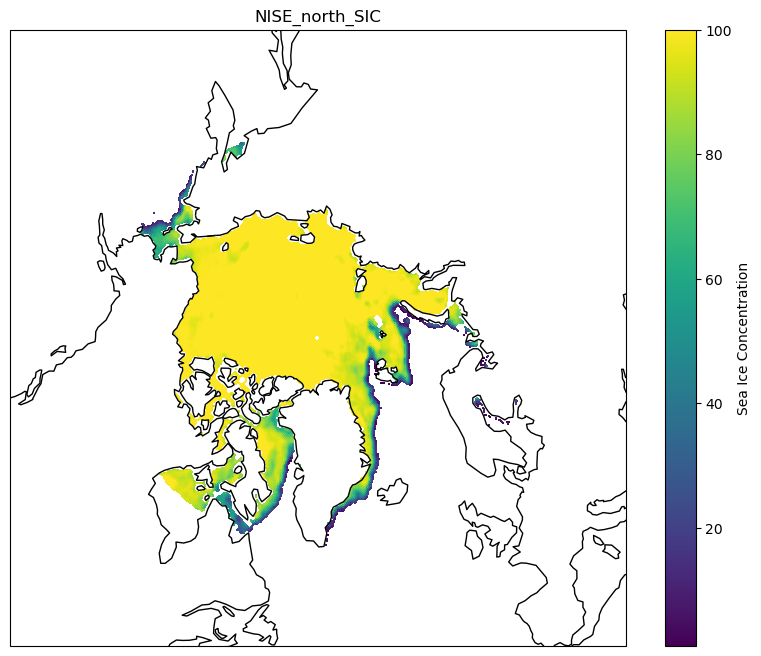

In [7]:
# Define the projection
crs_psn = ccrs.NorthPolarStereo(-45)

# Plot with cartopy
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=crs_psn)

# Plot the data
p = ax.pcolormesh(ds['lon'], ds['lat'], ds['ice_concentration'], transform=ccrs.PlateCarree(), cmap='viridis', shading='auto')

# Add coastlines for context
ax.coastlines()

# Add a colorbar
plt.colorbar(p, ax=ax, label='Sea Ice Concentration')

# Add a title
plt.title('NISE_north_SIC')

In [8]:
crs_wgs84 = CRS.from_epsg(4326)
crs_psn = CRS.from_epsg(3413)
transformer = Transformer.from_crs(crs_wgs84, crs_psn, always_xy=True)
lon = ds['lon'].values
lat = ds['lat'].values
x, y = transformer.transform(lon, lat)

In [9]:
# Assuming x and y are 2D arrays
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = ds['ice_concentration'].values.flatten()


In [21]:
# Interpolate data to regular grid
grid_data = griddata((x_flat, y_flat), z_flat, (grid_x_n, grid_y_n) )   # method="nearest"
grid_data.shape

(447, 303)

In [19]:
grid_data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Text(0.5, 1.0, 'NISE_north_SIC')

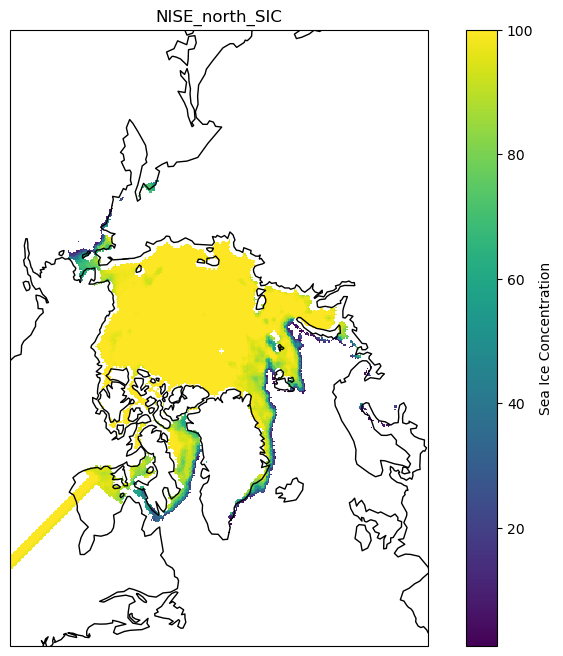

In [20]:
# Define the projection
crs_psn = ccrs.NorthPolarStereo(-45)

# Plot with cartopy
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=crs_psn)

# Plot the data
p = ax.pcolormesh(grid_x_n, grid_y_n, grid_data, transform=crs_psn, cmap='viridis', shading='auto')

# Add coastlines for context
ax.coastlines()

# Add a colorbar
plt.colorbar(p, ax=ax, label='Sea Ice Concentration')

# Add a title
plt.title('NISE_north_SIC')

In [14]:
# Create xarray DataArray
da = xr.DataArray(
    grid_data, 
    coords=[('y', grid_y_n[:, 0]), ('x', grid_x_n[0, :])],  # y and x are the grid coordinates
    dims=['y', 'x']
)

da.to_dataset(name='NISE_north_icecon')
# da.to_netcdf("NISE_icecon.nc")

<xarray.Dataset> Size: 1MB
Dimensions:            (y: 447, x: 303)
Coordinates:
  * y                  (y) float64 4kB -5.338e+06 -5.312e+06 ... 5.812e+06
  * x                  (x) float64 2kB -3.838e+06 -3.812e+06 ... 3.712e+06
Data variables:
    NISE_north_icecon  (y, x) float64 1MB nan nan nan nan ... nan nan nan nan

In [1]:
import numpy as np
import pandas as pd

# Grid information from the figure
ulxmap = -9036842.76  # Upper-left x coordinate (meters)
ulymap = 9036842.76   # Upper-left y coordinate (meters)
grid_size = 25067.53  # Grid cell size in meters
rows = 721            # Number of rows
cols = 721            # Number of columns

# Generate x and y coordinates for the grid
x_coords = np.linspace(ulxmap, ulxmap + grid_size * (cols - 1), cols)
y_coords = np.linspace(ulymap, ulymap - grid_size * (rows - 1), rows)

(721,)

## FY3D

In [9]:
ds = xr.open_dataset(r'/Volumes/zqk/zmh/icecon25000_data/ICECON_merge_25000/north/NSIDC-Bootstrap-Kalman/NSIDC-Bootstrap_north_25000_kalman_20220101.nc')
ds

<xarray.Dataset>
Dimensions:    (y: 447, x: 303)
Coordinates:
    time       datetime64[ns] ...
  * x          (x) float64 -3.838e+06 -3.812e+06 ... 3.688e+06 3.712e+06
  * y          (y) float64 -5.338e+06 -5.312e+06 ... 5.788e+06 5.812e+06
Data variables:
    ice_con    (y, x) float64 ...
    ice_con_P  (y, x) float64 ...